![alt text](<../Questão 1.png>)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parâmetros Hückel (unidades de |β|)
alpha_C = 0.0     # carbono pz
alpha_N = 0.5     # nitrogênio pz (valor escolhido para distinguir heteroátomos; justificarei no relatório)
beta = -1.0       # interação entre vizinhos (assumida -1 como unidade de energia)


#### Numeração escolhida (1..6) - começando num nitrogênio e seguindo o anel no sentido horário:

In [2]:
n = 6
atom_types = ['N','C','C','N','C','C']

# Construir matriz H de acordo com ligações de um anel de seis membros
H = np.zeros((n,n))
for i in range(n):
    H[i,i] = alpha_N if atom_types[i]=='N' else alpha_C
    # ligações ao vizinho à direita (anel)
    j = (i+1) % n
    H[i,j] = beta
    H[j,i] = beta

print("Matriz H de Hückel (α em diagonal, β nas ligações):\n", np.round(H,3))


Matriz H de Hückel (α em diagonal, β nas ligações):
 [[ 0.5 -1.   0.   0.   0.  -1. ]
 [-1.   0.  -1.   0.   0.   0. ]
 [ 0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.5 -1.   0. ]
 [ 0.   0.   0.  -1.   0.  -1. ]
 [-1.   0.   0.   0.  -1.   0. ]]


In [3]:
# Diagonalização com numpy (eigh é apropriado para matrizes simétricas/Hermitian)
eigvals_np, eigvecs_np = np.linalg.eigh(H)  # ordenados crescentemente
# Organizar por ordem decrescente de energia para conveniência (opcional)
idx_desc = eigvals_np.argsort()[::-1]
eigvals_np = eigvals_np[idx_desc]
eigvecs_np = eigvecs_np[:, idx_desc]

# Implementação simples do algoritmo QR iterativo (sem shift) para comparação
def qr_eigenvalues(A, max_iter=2000, tol=1e-10):
    A_k = A.copy()
    n = A_k.shape[0]
    for it in range(max_iter):
        Q,R = np.linalg.qr(A_k)
        A_k = R @ Q
        # verificar convergência pela soma dos quadrados dos off-diagonais
        off_diag_norm = np.sqrt(np.sum((A_k - np.diag(np.diag(A_k)))**2))
        if off_diag_norm < tol:
            break
    eigs_qr = np.diag(A_k)
    # ordenar decrescente
    idx = eigs_qr.argsort()[::-1]
    return eigs_qr[idx], np.round(it+1,0)

eigvals_qr, iters_used = qr_eigenvalues(H)
# Para comparação numérica, recolocar vectores de numpy ao lado de valores QR
print(f"\nEigenvalues (numpy.linalg.eigh) ordenados (decrescente):\n{np.round(eigvals_np,6)}")
print(f"Eigenvalues (QR iterativo) aproximados (decrescente), convergiu em {int(iters_used)} iterações:\n{np.round(eigvals_qr,6)}")



Eigenvalues (numpy.linalg.eigh) ordenados (decrescente):
[ 2.186141  1.350781  1.       -0.686141 -1.       -1.850781]
Eigenvalues (QR iterativo) aproximados (decrescente), convergiu em 148 iterações:
[ 2.186141  1.350781  1.       -0.686141 -1.       -1.850781]


#### Autovetores do numpy para construir matrizes de densidade e calcular ordens de ligação

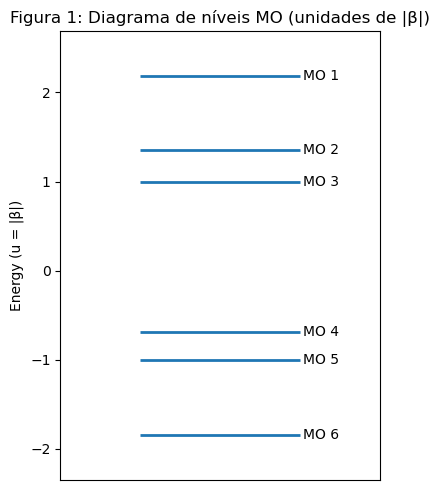

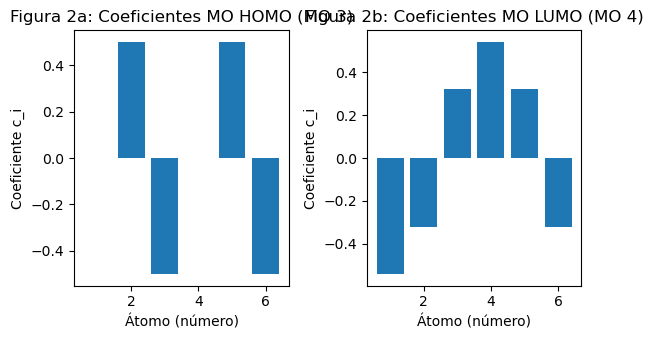

In [8]:
n_pi = 6
n_occ_orbitals = n_pi // 2  # 3 orbitais ocupados (2 elétrons cada)

# Ocupação: 2 elétrons por orbital ocupado
occupied_indices = np.arange(n_occ_orbitals)  # como eigvals_np está em ordem decrescente, ocupamos as primeiras 3
# construir matriz densidade: P = 2 * sum_{occ} c c^T
C = eigvecs_np  # colunas são autovetores (MO coefficients)
P = np.zeros((n,n))
for m in occupied_indices:
    cm = C[:, m].reshape(-1,1)
    P += 2.0 * (cm @ cm.T)

# ordens de ligação entre átomos i,j (i!=j), BO_ij = P_ij (no formalismo Hückel ortonormal)
bond_orders = []
for i in range(n):
    j = (i+1) % n
    bo = P[i,j]
    bond_orders.append((i+1, j+1, atom_types[i], atom_types[j], bo))

# Montar tabela com energias (em unidades de |β|) e ocupação
energies = eigvals_np  # já em unidades do que inserimos (α,β presentes)
occupations = [2 if i < n_occ_orbitals else 0 for i in range(n)]

df_energies = pd.DataFrame({
    "MO index (desc)": np.arange(1,n+1),
    "Energy (u = |β|)": np.round(energies,6),
    "Occupation": occupations
})

# Tabela de ordens de ligação para ligações na molécula (1-2,2-3,...,6-1)
df_bonds = pd.DataFrame(bond_orders, columns=["i","j","atom_i","atom_j","Bond order (P_ij)"])
df_bonds["Bond order (P_ij)"] = df_bonds["Bond order (P_ij)"].round(6)

# Mostrar tabelas


# Plot: diagrama de níveis de energia (cada MO como linha horizontal) - figura 1
plt.figure(figsize=(4,5))
for k,E in enumerate(energies):
    plt.hlines(E, xmin=0, xmax=1, linewidth=2)
    plt.text(1.02, E, f"MO {k+1}", va='center')
plt.xlim(-0.5,1.5)
plt.ylim(energies.min()-0.5, energies.max()+0.5)
plt.gca().axes.get_xaxis().set_visible(False)
plt.title("Figura 1: Diagrama de níveis MO (unidades de |β|)")
plt.ylabel("Energy (u = |β|)")
plt.tight_layout()
plt.show()


# Plot: coeficientes da HOMO e LUMO (figura 2)
homo_idx = n_occ_orbitals - 1  # índice de HOMO (0-based)
lumo_idx = n_occ_orbitals      # índice de LUMO
plt.figure(figsize=(6,3.5))
plt.subplot(1,2,1)
plt.bar(np.arange(1,n+1), C[:,homo_idx])
plt.title(f"Figura 2a: Coeficientes MO HOMO (MO {homo_idx+1})")
plt.xlabel("Átomo (número)")
plt.ylabel("Coeficiente c_i")

plt.subplot(1,2,2)
plt.bar(np.arange(1,n+1), C[:,lumo_idx])
plt.title(f"Figura 2b: Coeficientes MO LUMO (MO {lumo_idx+1})")
plt.xlabel("Átomo (número)")
plt.ylabel("Coeficiente c_i")
plt.tight_layout()
plt.show()